In [392]:
import torch
import torch.nn.functional as F
import random
from IPython import display 
import matplotlib.pyplot as plt

In [393]:
# Get the device
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    device = torch.cuda.current_device() 
else:
    device = 'cpu'
print(device)

0


In [394]:
# Set the generator
g = torch.Generator().manual_seed(114135)

# Data loading and preprocessing

In [395]:
# Read the dataset
with open('data/names.txt', 'r') as f:
    names_list = f.read().splitlines()

# Get all characters in the name_list
all_chars = sorted(list(set(''.join(names_list))))

# Encoding alphabet using numbering 
# Also using the char '.' to replace the <S> and <E>, the '.' is denoted as 0
stoi = {s:i+1 for i, s in enumerate(all_chars)}
stoi['.'] = 0

# Decoding
itos = {i:s for s, i in stoi.items()}

# Get the number of all_chars list
char_num = len(stoi)

In [396]:
def built_dataset(text, ws, show=False, shuffle=False):
    """ Build the dataset
    text: the raw text
    ws: the number of token for predicting next char
    show: whether show samples in the dataset, default to fault
    """
    X, Y = [], []
    
    if shuffle:
    # Shuffle the x and y
        random.seed(345567)
        random.shuffle(text)

    for t in text:
        # Clean up the window for the next name
        content = [0] * ws

        for c in t + '.':
            X.append(content)
            Y.append(stoi[c])
            content = content[1:] + [stoi[c]]
            if show:
                print(''.join(itos[i] for i in content), '--->', c)

    return torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [397]:
def split_dataset(x, y, tr_rate=0.8, va_rate=0.1):
    assert len(x) == len(y), "The length of two given arrays are not compatiable "

    tr_num = int(tr_rate * len(x))
    va_num = int((tr_rate + va_rate) * len(x))
    
    return x[:tr_num], y[:tr_num], x[tr_num:va_num], y[tr_num:va_num], x[va_num:], y[va_num:]

In [398]:
# The window size = 8, then it use 8 tokens to predict the next chars
window_size = 8
xs, ys = built_dataset(text=names_list, ws=window_size, shuffle=True)
x_tr, y_tr, x_va, y_va, x_te, y_te = split_dataset(xs, ys)
print(x_tr[10:15])
print(y_tr[10:15])

tensor([[ 0,  0, 10,  1, 25, 19,  9,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0,  0,  0,  0,  0, 19, 25],
        [ 0,  0,  0,  0,  0, 19, 25,  2]], device='cuda:0')
tensor([ 0, 19, 25,  2,  5], device='cuda:0')


# Building blocks of the model

In [399]:
class Embedding:
    """ The embedding layer """

    def __init__(self, num_embeddings, embedding_dim, device=None) -> None:
        self.w = torch.randn((num_embeddings, embedding_dim), device=device)

    def __call__(self, x):
        self.out = self.w[x]
        return self.out
    
    def parameters(self):
        return [self.w]

In [400]:
class Linear:
    """ The Linear layer defined using same API in Pytorch """

    def __init__(self, in_features, out_features, bias=True, device=None) -> None:
        self.w = torch.randn((in_features, out_features), device=device) / (in_features ** 0.5)
        self.b = torch.zeros(out_features, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([] if self.b is None else [self.b])

In [401]:
class BatchNorm1D:
    """ Batch normalization for 1D data """

    def __init__(self, dim, eps=1e-5, momentum=0.1, device=None) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # trainable parameters 
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)

        # buffer (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        # Compute the mean and variance on the batch
        # Along all samples
        if self.training:
            # Select the axis (dim) to get the mean and variance
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            x_mean = x.mean(dim, keepdim=True)
            x_var = x.var(dim, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        # Update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var        
        
        # Normalize and scale as shown in the third and fourth steps in the image to return the result
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps) # Normalize
        self.out = self.gamma * x_hat + self.beta           # Scale 
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [402]:
class Flatten:
    """ concatnate the n_emb and emb_dim, while only retain the batch size """

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [403]:
class FlattenConsecutive:

    def __init__(self, n) -> None:
        # The consecutive number 
        # (1) (2) (3) (4) (5) (6) (7) (8) => consecutive number is 1
        # (1 2) (3 4) (5 6) (7 8) => consecutive number is 2
        # (1 2 3 4) (5 6 7 8) => consecutive number is 4
        # (1 2 3 4 5 6 7 8) => consecutive number is 8
        self.n = n 
    
    def __call__(self, x):
        B, T, C = x.shape # B is the batch size, T is the block size, C is the emb_dim
        temp = x.view(B, T // self.n, C * self.n)
        # If T // n == 1, then just return the tensor as Flatten layer does
        if temp.shape[1] == 1:
            temp = temp.squeeze(dim=1) # (B, 1, C*n) => (B, C*n)
        self.out = temp
        return self.out
    
    def parameters(self):
        return []


In [404]:
class Tanh:
    """ tanh activation for nonlinearty """
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [405]:
class Sequential:
    """ Define a container for running a stack of layers """

    def __init__(self, layers) -> None:
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Built the network

In [406]:
# Create the look up table, suppose the embedding space is n-dimensional
# then the size of the lookup table is [27, n] (n components for representing each char)
n_emb = 8
n_hidden = 64

In [407]:
# Define the network as a stack of building block
model = Sequential([
    Embedding(char_num, n_emb, device=device),
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(n_hidden, char_num, bias=False, device=device),
])

In [408]:
# Initialize all weights in the network 
with torch.no_grad():
    model.layers[-1].w *= 0.1 # Less confident in the final layer

    # Initialize all other parameters using Kaiming init 5/3
    for layer in model.layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 5/3

In [409]:
# Get all parameters
params = model.parameters()

# Set all parameters gradient to true
for p in params:
    p.requires_grad = True

# Show all layers info in the model
for l in model.layers:
    print(f'{l.__class__.__name__}')

n_params = sum(p.nelement() for p in params)
print(f'Total number of parameters {n_params}')

Embedding
FlattenConsecutive
Linear
BatchNorm1D
Tanh
FlattenConsecutive
Linear
BatchNorm1D
Tanh
FlattenConsecutive
Linear
BatchNorm1D
Tanh
Linear
Total number of parameters 19736


# Train the network

## A small demo


In [410]:
rand_idx = torch.randint(0, x_tr.shape[0], (4, )) # Extract 4 samples from the training set
rand_x, rand_y = x_tr[rand_idx], y_tr[rand_idx]
rand_logits = model(rand_x)

In [411]:
# print(f'The shape of inputs: {rand_x.shape}')
# print(rand_x)
# print(f'The shape of logits: {rand_logits.shape}')
# print(rand_logits)

In [412]:
for layer in model.layers:
    print(f'{layer.__class__.__name__} : {layer.out.shape}')

Embedding : torch.Size([4, 8, 8])
FlattenConsecutive : torch.Size([4, 4, 16])
Linear : torch.Size([4, 4, 64])
BatchNorm1D : torch.Size([4, 4, 64])
Tanh : torch.Size([4, 4, 64])
FlattenConsecutive : torch.Size([4, 2, 128])
Linear : torch.Size([4, 2, 64])
BatchNorm1D : torch.Size([4, 2, 64])
Tanh : torch.Size([4, 2, 64])
FlattenConsecutive : torch.Size([4, 128])
Linear : torch.Size([4, 64])
BatchNorm1D : torch.Size([4, 64])
Tanh : torch.Size([4, 64])
Linear : torch.Size([4, 27])


In [413]:
model.layers[0].out.shape # The Embedding layer output

torch.Size([4, 8, 8])

In [414]:
model.layers[1].out.shape # The Flatten layer output
# It only remain the batch size 
# and concentate the n_emb and emb_dim, which is n_emb * emb_dim 

torch.Size([4, 4, 16])

In [415]:
model.layers[2].out.shape # The linear layer output

torch.Size([4, 4, 64])

In [416]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 64])

In [417]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [418]:
e = torch.randn(4, 8, 10)
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

## A final training 

In [419]:
# Optimization
steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(steps):

    # Get minibatch from the dataset
    ix = torch.randint(0, x_tr.shape[0], (batch_size,), device=device)
    samples, labels = x_tr[ix], y_tr[ix]

    # Forward pass
    logits = model(samples)

    # Compute the loss using the cross entropy function
    loss = F.cross_entropy(logits, labels)

    # # Backward
    for p in params:
        p.grad = None
    loss.backward()

    # # Update
    lr = 0.1 if i < 150000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    # Track loss and state
    if i % 10000 == 0:
        print(f'{i:7d}/{steps:7d}: Loss={loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in params])

    # if i >= 1000: # For DEBUG
    # break

      0/ 200000: Loss=3.2988
  10000/ 200000: Loss=2.0176
  20000/ 200000: Loss=2.3643
  30000/ 200000: Loss=2.2446
  40000/ 200000: Loss=2.1402
  50000/ 200000: Loss=1.9885
  60000/ 200000: Loss=2.6257
  70000/ 200000: Loss=2.0432
  80000/ 200000: Loss=2.0642
  90000/ 200000: Loss=2.0902
 100000/ 200000: Loss=2.1859
 110000/ 200000: Loss=1.8540
 120000/ 200000: Loss=2.3228
 130000/ 200000: Loss=2.2077
 140000/ 200000: Loss=2.1383
 150000/ 200000: Loss=2.5847
 160000/ 200000: Loss=2.1436
 170000/ 200000: Loss=1.7624
 180000/ 200000: Loss=2.4291
 190000/ 200000: Loss=2.4738


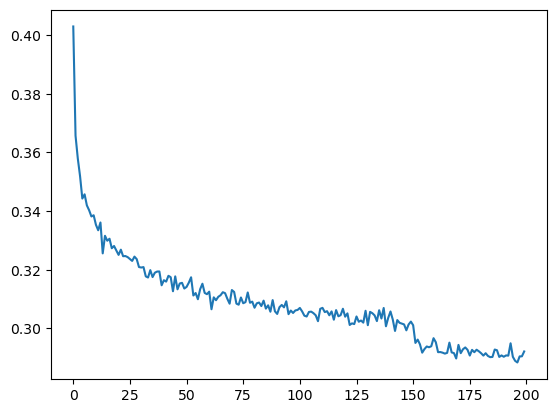

In [420]:
# Show the loss during the training
plt.plot(torch.tensor(lossi).view(200, -1).mean(1))

# Save and load the model

In [421]:
# Save parameters
embedding_stack = []
linear_stack = []
bn_gamma_stack = []
bn_beta_stack = []
bn_running_mean_stack = []
bn_running_var_stack = []

for layer in model.layers:
    if isinstance(layer, Embedding):
        embedding_stack.append(layer.w)
    if isinstance(layer, Linear):
        linear_stack.append(layer.w)
    if isinstance(layer, BatchNorm1D):
        bn_running_mean_stack.append(layer.running_mean)
        bn_running_var_stack.append(layer.running_var)
        bn_gamma_stack.append(layer.gamma)
        bn_beta_stack.append(layer.beta)
    if isinstance(layer, Tanh):
        continue

torch.save(embedding_stack, 'params/wavenet/emb.pt')
torch.save(linear_stack, 'params/wavenet/l_w.pt')
torch.save(bn_running_mean_stack, 'params/wavenet/bn_rm.pt')
torch.save(bn_running_var_stack, 'params/wavenet/bn_rv.pt')
torch.save(bn_gamma_stack, 'params/wavenet/bn_gamma.pt')
torch.save(bn_beta_stack, 'params/wavenet/bn_beta.pt')

In [422]:
# Load the parameters
embeddings = torch.load('params/wavenet/emb.pt')
linear_weights = torch.load('params/wavenet/l_w.pt')
bn_gammas = torch.load('params/wavenet/bn_gamma.pt')
bn_betas = torch.load('params/wavenet/bn_beta.pt')
bn_rm = torch.load('params/wavenet/bn_rm.pt')
bn_rv = torch.load('params/wavenet/bn_rv.pt')

In [423]:
# Re-define a new model
r_model = Sequential([
    Embedding(char_num, n_emb, device=device),
    FlattenConsecutive(2), Linear(n_emb * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1D(n_hidden, device=device), Tanh(),
    Linear(n_hidden, char_num, bias=False, device=device),
])

In [424]:
# Assign all parameters to the new defined model
lw_idx = 0
bn_idx = 0
for layer in r_model.layers:
    if isinstance(layer, Embedding):
        layer.w = embedding_stack[0]
    if isinstance(layer, Linear):
        layer.w = linear_weights[lw_idx]
        lw_idx += 1
    if isinstance(layer, BatchNorm1D):
        layer.gamma = bn_gammas[bn_idx]
        layer.beta = bn_betas[bn_idx]
        layer.running_mean = bn_rm[bn_idx]
        layer.running_var = bn_rv[bn_idx]
        bn_idx += 1
    if isinstance(layer, Tanh) or isinstance(layer, FlattenConsecutive):
        continue

# Loss on the Test and Validate set

In [425]:
for layer in r_model.layers:
    layer.training = False

In [426]:
@torch.no_grad()
def compute_loss(dataset):
    # Get the select dataset for loss computation
    x, y = {'train': (x_tr, y_tr), 'valid': (x_va, y_va), 'test': (x_te, y_te)}[dataset]

    # Forward pass to the model to get prediction
    x_preds = r_model(x)

    # Compute the loss
    return F.cross_entropy(x_preds, y).item()

In [427]:
train_loss = compute_loss('train')
print(f'Loss on train-set is {train_loss:.4f}')
valid_loss = compute_loss('valid')
print(f'Loss on valid-set is {valid_loss:.4f}')
test_loss = compute_loss('test')
print(f'Loss on test-set is {test_loss:.4f}')

Loss on train-set is 1.9358
Loss on valid-set is 2.0249
Loss on test-set is 2.0234


## Performance log
Averaged negative log likelihodd on the whole dataset: 2.4544  
MLP  
2 block-size(no emb) + 1 * hidden( 27)  totally  729 params: train 2.4955  
3 block-size(emb 10) + 2 * hidden(200) totally 11897 params: train       , val 2.2924, test 2.2785 (with random Init)  
3 block-size(emb 10) + 2 * hidden(200) totally 11897 params: train       , val 2.1861, test 2.1739 (with selected Init)    
3 block-size(emb 10) + 2 * hidden(200) totally 11897 params: train       , val 2.1521, test 2.1367 (with Kaiming Init)  
3 block-size(emb 10) + 2 * hidden(200) totally 12097 params: train 2.0906, val 2.1411, test 2.1276 (with BN + Init)  
3 block-size(emb 10) + 5 * hidden(100) totally 36770 params: train 2.0120, val 2.0940, test 2.0829 (with BN + Init)  
8 block-size(emb 10) + 2 * hidden(200) totally 22070 params: train 1.9291, val 2.0344, test 2.0219 (with BN + Init)  
WaveNet    
8 block-size(emb 8)  + 3 * hidden( 64) totally 19736 params: train 1.9358, val 2.0249, test 2.0234  
8 block-size(emb 16) + 3 * hidden( 64) totally 20976 params: train 1.9157, val 2.0250, test 2.0067    
8 block-size(emb 16) + 3 * hidden(128) totally 74288 params: train 1.7836, val 1.9974, test 1.9859  
8 block-size(emb 32) + 3 * hidden(256) totally 287840 params: train 1.6689, val 2.0040, test 1.9984 (overfitting)



# Generate new names

In [428]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

In [429]:
for _ in range(20):
    names = []

    context = [0] * window_size
    while True:
        # Again, forward pass to the model
        logits = r_model(torch.tensor([context], device=device))
        
        # Get the char with the maximum possibility (maximum likelihood)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # Get the new and next combinations for prediction
        # Break when meets the '.', or say 0 in the index list
        if ix != 0:
            context = context[1:] + [ix]
            names.append(ix)
        else:
            break

    print(''.join(itos[i] for i in names))

jain
bashady
bryce
taruba
khumario
kahsyn
thumor
ayshaum
kinda
deeryn
smuelle
zayder
elli
lucaijah
brayleigh
guhnem
yuslei
wylan
cyre
kenzie
